# CS109B: Final project - Milestone 1

### Team members
- Angela Ambroz (HUID: 61126945)
- Keun-Hwi Lee (HUID: 20988185)
- Johanna Ramos (HUID: 70989328)
- Pranav Sidhwani (HUID: 50988260)



# Overview
In preparing this milestone, we divided up the task among the team members like so:
- **Quinn** handled the main data engineering task, pulling in data from the following sources: all movie data from 1970 onward from IMDb and TMDb, as well as the [Kaggle dataset](https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset). He conducted EDA in IPython.
- **Angela** wrote the demo API pulls from the initial exploratory data analysis (EDA) of the TMDb and IMDb. 
- **Pranav and Johanna** create EDA visualizations in R Markdown.
- **Together**, the entire team coordinated and brainstormed questions to answer and - in particular - ideas for identifying a suitable $y$ variable, given genres are subjective, crowd-sourced and vary among data sources.

# Table of Contents
Using the `FinalProject.ipynb` as a guide, here is our Table of Contents.
- [API code to access the genre and movie poster path of your favorite movie](#api_code)
- [Genre for this movie listed by TMDb and IMDb](#genre)
- [A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via the API](#top_10)
- [Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them](#comments)
- [Code to generate the movie genre pairs and a suitable visualization of the result](#bigrams)
- [Additional visualization sketches and EDA with a focus on movie genres](#eda)
- [A list of questions you could answer with this and related data. Get creative here!](#questions)


<hr>

## <a id="api_code"></a> API code to access genre and movie poster path for your favorite movie

Our project (currently in a private GitHub repo) is organized such that notebooks - such as this - pull modules from a `src` folder. The code to grab things from the TMDb API is in `src/tmdb.py`. 

In [12]:
%matplotlib inline

import os
import sys
import pandas as pd
from imdb import IMDb
from unidecode import unidecode
from IPython.display import Image, display

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

# Importing the tmdb code from src/data
from data import tmdb

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Master list of TMDb genres

In [14]:
genres = pd.DataFrame(tmdb.get_genres()['genres'])
print(genres.shape)
genres.head()

(19, 2)


,id,name
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime


### A specific movie's info
[TMDb documentation for searching for movies.](https://developers.themoviedb.org/3/search/search-movies)

In [34]:
example = tmdb.find_movie_by_name('Allonsanfan')['results']
print(len(example))

1



**Allonsanfan**
Suave Fulvio (Marcello Mastroianni) woos women as he and the Sublime Brothers, 20 of them, attempt revolution in 1816 Italy.
Genres: ['Drama', 'History']


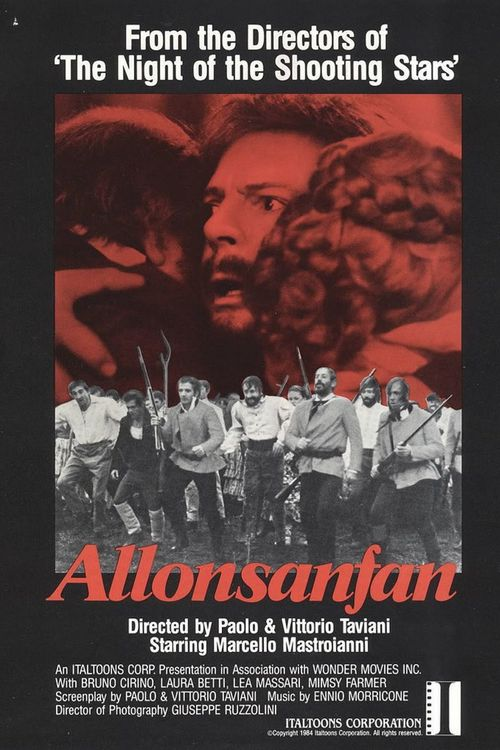

In [35]:
for i in range(0, len(example)):
    print('\n**{}**\n{}'.format(example[i]['title'], unidecode(example[i]['overview'])))
    genre_string_list = [unidecode(genres[genres['id'] == x]['name'].item()) if genres[genres['id'] == x].shape[0]>0 else 'none' for x in example[0]['genre_ids']]
    print('Genres: {}'.format(genre_string_list))
    if example[i]['poster_path'] is not None:
        poster = "{}{}".format("https://image.tmdb.org/t/p/w500/", example[i]['poster_path'])
        display(Image(poster))

## <a id="genre"></a>Genre for this movie from IMDb and TMDb

In [36]:
def get_tmdb_genres(row):
    return [unidecode(genres[genres['id'] == x]['name'].item()) if genres[genres['id'] == x].shape[0]>0 else 'none' for x in row['genre_ids']]

def get_imdb_genres(row):
    ia = IMDb()
    imdb_movie_object = ia.search_movie(row['original_title'])[0]
    ia.update(imdb_movie_object)
    return imdb_movie_object['genres']

In [37]:
movie = pd.DataFrame(example)
movie['tmdb_genres'] = movie.apply(lambda x: get_tmdb_genres(x), axis = 1)
movie['imdb_genres'] = movie.apply(lambda x: get_imdb_genres(x), axis = 1)
movie[['original_title', 'release_date', 'imdb_genres', 'tmdb_genres']].head()

,original_title,release_date,imdb_genres,tmdb_genres
0,Allonsanfàn,1974-12-08,"[Drama, History]","[Drama, History]"


### <a id="top_10"></a>Most popular movies from 2016 + their genres

TMDb returns stuff in JSON chunks. You can use `total_pages` and `total_results` to see the total number of data  points they can return. Here we just want the top 10 for year 2016.

In [21]:
# First two pages of results
page_1 = tmdb.get_popular()['results']
pages = page_1 + tmdb.get_popular(2)['results']

popular = pd.DataFrame(pages)
print(popular.shape)
recent_popular = popular[(popular['release_date'] >= '2016') & (popular['release_date'] < '2017')].copy()
print(recent_popular.shape)

(40, 14)
(18, 14)


In [22]:
recent_popular['tmdb_genres'] = recent_popular.apply(lambda x: get_tmdb_genres(x), axis = 1)
recent_popular['imdb_genres'] = recent_popular.apply(lambda x: get_imdb_genres(x), axis = 1)
recent_popular[['original_title', 'tmdb_genres', 'imdb_genres', 'popularity']].head(10)

,original_title,tmdb_genres,imdb_genres,popularity
2,Sing,"[Animation, Comedy, Drama, Family, Music]","[Animation, Comedy, Family, Music]",76.005907
6,Fantastic Beasts and Where to Find Them,"[Adventure, Action, Fantasy]","[Adventure, Family, Fantasy]",39.239379
10,Finding Dory,"[Adventure, Animation, Comedy, Family]","[Animation, Adventure, Comedy, Family]",31.769363
14,Deadpool,"[Action, Adventure, Comedy, Romance]","[Action, Adventure, Comedy, Romance, Sci-Fi]",26.382598
15,Rogue One: A Star Wars Story,"[Action, Drama, Science Fiction, War]","[Action, Adventure, Sci-Fi]",25.082126
16,Doctor Strange,"[Action, Adventure, Fantasy, Science Fiction]","[Action, Adventure, Fantasy, Sci-Fi]",23.441433
17,Arrival,"[Drama, Science Fiction]","[Drama, Mystery, Sci-Fi, Thriller]",22.476241
18,Captain America: Civil War,"[Action, Science Fiction]","[Action, Adventure, Sci-Fi]",21.467025
20,Underworld: Blood Wars,"[Action, Horror]","[Action, Horror]",20.082001
22,Lion,[Drama],"[Biography, Drama]",15.298543


## <a id="comments"></a> Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them

Movie “genres” are not objectively defined, but rather reflect subjective decisions by movie connoisseurs or the crowd. Sampling The Movie Database (TMDb) and the Internet Movie Database (IMDb), the same movies will often result in slightly different genres. Sing (2016), for example, is listed by the TMDb as being `[Animation, Comedy, Drama, Family, Music]` - while IMDb lists it as `[Animation, Comedy, Family, Music]`. Here, there is only a single difference (`Drama`) - other films diverge more.

Given that genre is our predictee (our $y$ variable), we face two particular challenges: 
1. **How to reconcile genre disagreements among different data sources.** We can study movie-by-movie percentage of agreement. For example, if a movie x is listed as having genres [A, B, C] in one dataset, and [A, C, D] in another, then we would list that as having 66.67% agreement. (This would be a simpler version of something like the Levenshtein distance.)
2. **How to predict genres, when a movie may have arbitrarily many genres.** It is rare that movies are associated with only a single genre. Instead, we have seen that movies typically have several genres. Once we have identified the “most likely” genres attributed to those movies from the different datasets, we have to decide how to predict them. We have three options:
    1. **Reduce each movie to having a single genre.** This simplification would allow for much easier prediction (it would become a multi-class classification problem). However, it is unclear - a priori - how to determine a film’s “dominant” genre. We had several ideas. We could pick, for example, the more renowned/less rare genre as a movie's dominant genre. (We would do this by visualizing a frequency histogram of single genres and then picking each movie's most popular genre.) This would account for very specific, rare genres that are difficult to predict - the long tail of genres could simply be grouped into an `Other` category which we could predict. Another option would be to "oversample" movies - cloning a movie's observations for each genre that it has listed, and then predicting on those. This would reduce the variance in our $X$ (e.g. movie posters), however, while keeping our $y$ (e.g. genres) variance constant. 
    2. **Predict each movie’s specific set of genres.** For example, if movie x has genres [A, B, C], we would build a model to specifically predict those three genres. Predicting, for example, [A, B] would result as a misclassification error. The challenge here, however, is that the arbitrarily-long genre lists may be fairly unique to each movie. The frequency of each combination of genres will likely be very low. 
    3. **Reduce genres into meta-“supersets", and predict those.** Some genres frequently co-occur: for example, Action and Drama, or Animation and Family. Indeed, genres have nebulous borders. We could thus reduce the problem’s dimensionality by clustering genres. These clusters would capture the “meta-genres” - genre clusters that represent higher-level film categories (for example, “dark” films, “children’s” films, and so on). This could serve as an effective compromise between (1) predicting a single genre per film, and (2) predicting each film’s specific combinations of genres.


## <a id="bigrams"></a> Code to generate the movie genre pairs and a suitable visualization of the result

We used `R Markdown` to analyze and visualize genre bigrams. You can find the full code in `JR_PS_Milestone1_EDA.Rmd` (also submitted). We relied on the Kaggle dataset for EDA; it contains the full sample of movies for which revenues and budgets were also available. Given that these may be important predictors, we decided it would be valuable to explore. We also compared this against the TMDb and IMDb data we downloaded as well, as a check of representativeness.

We visualized bigrams, first, as a heatmap between genre pairs, and, secondly, as a network graph between all genre combinations. In the latter, node size is frequency of the specific genre, and link width is the frequency of co-occurence. 

![bigram_heatmap](ML1_Bigram.png)

![bigram_network](ML1_Network.png)

## <a id="eda"></a> Additional visualization sketches and EDA with a focus on movie genres

Code for these is simmilarly in `JR_PS_Milestone1_EDA.Rmd`.

![eda1](ML1_EDA1.png)
![eda2](ML1_EDA2.png)
![eda3](ML1_EDA3.png)

We also duplicated some EDA on both the Kaggle and full TMDb datasets, to ensure that things looked the same. For example, looking at the relationship between the number of genres a movie has listed and its rating, we found similar results using the TMDb and Kaggle datasets:

EMDb: <img src="ML1_EDA5.png" width="400"> 
Kaggle: <img src="ML1_EDA4.png" width="400">

(Code for the TMDb visualization is in `ql-data-exploration-milestone1.ipynb`.)


## <a id="questions"></a> A list of questions you could answer with this and related data.

As is typical, the datasets raised more questions than we were able to answer in this initial week of project work. Here were some which we discussed:
- How do genres change over time? We speculated that including release date as a feature would account for this. See, for example, Slate's 2012 article: [Can We Graph Trends in Movie Genres?](http://www.slate.com/blogs/browbeat/2012/10/11/film_genre_graph_chart_of_percentages_over_time_goes_viral_on_reddit.html)
- We discovered that the Kaggle movies were selected based on budget data availability. Given that, how does movie budget correlate with genres?
- Are certain genres (or combinations of genres) more visually identifiable - for example, we expect that children's films will have easily distinguishable poster aesthetics, while drama films may have a larger variance (from dark/moody aesthetics to highly abstract ones). The latter will mean greater error rates on predicting movie genres whose posters are less visually identifiable.
- How do directors, cinematographers, actors and soundtrack composers predict genres? As an anecdotal reminder that this isn't clear cut, the same director (George Miller) directed both Mad Max: Fury Road and Happy Feet.

We already made some _ex ante_ decisions by limiting ourselves to English-language movies from 1970 onward. This already simplifies our problem (we no longer need to worry about comparing aesthetic/visual languages across Hollywood and Bollywood, for example). However, there are a number of additional decisions we will need to take: namely, **how will we define our $y$?** That will be the next step in our exploratory process. 